In [ ]:
!pip install requests beautifulsoup4
!pip install pyvi
!pip install -U transformers tokenizers

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

### Bước 1:(Preprocessing)

In [ ]:
import pandas as pd
import re
from pyvi import ViTokenizer

# 1. Load dữ liệu (Đảm bảo đường dẫn chính xác)
path = '/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal/vnexpress_filtered.csv'
df = pd.read_csv(path)

# 2. Hàm làm sạch văn bản tối ưu cho Tiếng Việt
def preprocess_text(text):
    text = str(text).lower()
    # Regex này giữ lại chữ cái Tiếng Việt, số và khoảng trắng, loại bỏ ký tự đặc biệt [cite: 63]
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Xóa khoảng trắng thừa
    text = ViTokenizer.tokenize(text) # Tách từ: "kinh tế" -> "kinh_tế"
    return text

print("Đang tiền xử lý văn bản...")
print("Đang tạo cột text_clean...")
df['text_clean'] = df['text'].apply(preprocess_text)

# 3. Thống kê theo yêu cầu 1.3 [cite: 29]
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))

print("\n--- BÁO CÁO THỐNG KÊ (Yêu cầu 1.3) ---")
print(f"1. Tổng số mẫu: {len(df)}")
print(f"2. Độ dài văn bản trung bình (Mean): {df['word_count'].mean():.2f} từ")
print(f"3. Độ dài văn bản trung vị (Median): {df['word_count'].median()} từ")
print("\n4. Số lượng mẫu mỗi lớp (Class Distribution):")
print(df['label'].value_counts())
print("\n5. Tỷ lệ mất cân bằng lớp:")
print(df['label'].value_counts(normalize=True) * 100)

Đang tiền xử lý văn bản...
Đang tạo cột text_clean...

--- BÁO CÁO THỐNG KÊ (Yêu cầu 1.3) ---
1. Tổng số mẫu: 2325
2. Độ dài văn bản trung bình (Mean): 505.13 từ
3. Độ dài văn bản trung vị (Median): 448.0 từ

4. Số lượng mẫu mỗi lớp (Class Distribution):
label
Kinh doanh      596
Bất động sản    596
Xe              578
Khoa học        555
Name: count, dtype: int64

5. Tỷ lệ mất cân bằng lớp:
label
Kinh doanh      25.634409
Bất động sản    25.634409
Xe              24.860215
Khoa học        23.870968
Name: proportion, dtype: float64


### Bước 2: Chia tập dữ liệu

#80/10/10

In [ ]:
# 1. Định nghĩa bảng ánh xạ nhãn (Mapping)
# Lưu ý: Tên các key ('Kinh doanh', 'Khoa học',...) phải khớp hoàn toàn với dữ liệu trong cột nhãn của bạn
label_map = {
    'Kinh doanh': 0,
    'Khoa học': 1,
    'BĐS': 2,
    'Xe': 3
}

# 2. Gán giá trị cho OUTPUT_DIM
OUTPUT_DIM = len(label_map)

print(f"Đã khởi tạo label_map thành công. Số lượng nhãn: {OUTPUT_DIM}")

Đã khởi tạo label_map thành công. Số lượng nhãn: 4


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Added this block to define df if it's not already in memory
try:
    df # Check if df is already defined
except NameError:
    # If df is not defined, load it from the CSV.
    # This loads the raw CSV which contains the 'label' column needed for stratification.
    path = '/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal/vnexpress_filtered.csv'
    df = pd.read_csv(path)

# 1. Chia 80% Train, 20% còn lại cho Val & Test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 2. Chia 20% đó thành Val (10%) và Test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Kích thước các tập: Train ({len(train_df)}), Val ({len(val_df)}), Test ({len(test_df)})")

# Lưu lại các tập để sử dụng thống nhất cho 5 mô hình
train_df.to_csv('/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal/train.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal/val.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal/test.csv', index=False)

Kích thước các tập: Train (1860), Val (232), Test (233)


# Xây dựng vocab

In [ ]:
from collections import Counter

# Lấy từ vựng duy nhất từ tập Train
all_words = ' '.join(train_df['text_clean']).split()
word_counts = Counter(all_words)

# Tạo vocab với các từ xuất hiện ít nhất 2 lần để giảm OOV (Out-of-vocabulary) [cite: 33]
vocab = {word: i + 2 for i, (word, count) in enumerate(word_counts.items()) if count >= 2}
vocab['<PAD>'] = 0  # Padding cho văn bản ngắn [cite: 89]
vocab['<UNK>'] = 1  # Cho các từ lạ [cite: 33]

print(f"Kích thước Vocabulary: {len(vocab)}")

Kích thước Vocabulary: 14908


In [ ]:
# 1. Tạo label_map từ cột 'label' thực tế
# Dựa trên dữ liệu của bạn: 'Xe', 'Kinh doanh', 'Khoa học', 'BĐS'
categories = train_df['label'].unique()
label_map = {cat: i for i, cat in enumerate(categories)}

# 2. Gán OUTPUT_DIM dựa trên số lượng nhãn thực tế tìm được
OUTPUT_DIM = len(label_map)

print(f"Danh sách nhãn tìm thấy: {categories}")
print(f"Bảng ánh xạ (label_map): {label_map}")
print(f"OUTPUT_DIM = {OUTPUT_DIM}")

# 3. Quan trọng: Tạo một cột số (ví dụ 'label_id') để train mô hình
# Vì Pytorch cần nhãn ở dạng số (integer) chứ không phải dạng chữ
train_df['label_id'] = train_df['label'].map(label_map)
test_df['label_id'] = test_df['label'].map(label_map)

Danh sách nhãn tìm thấy: ['Xe' 'Bất động sản' 'Khoa học' 'Kinh doanh']
Bảng ánh xạ (label_map): {'Xe': 0, 'Bất động sản': 1, 'Khoa học': 2, 'Kinh doanh': 3}
OUTPUT_DIM = 4


### Bước 3: Bộ 5 mô hình tối thiểu (khuyến nghị chuẩn hoá)

##  1. KimCNN

In [ ]:
# Dataloader
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1. Hàm chuyển văn bản thành chuỗi số (Padding/Truncate)
def text_to_sequence(text, vocab, max_len=300):
    tokens = text.split()
    sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(sequence) < max_len:
        sequence += [vocab['<PAD>']] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    return sequence

# 2. Tạo lớp Dataset
class NewsDataset(Dataset):
    def __init__(self, df, vocab, label_map, max_len=300):
        self.sequences = [text_to_sequence(t, vocab, max_len) for t in df['text_clean']]
        self.labels = [label_map[l] for l in df['label']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

# Ánh xạ nhãn
label_map = {label: i for i, label in enumerate(train_df['label'].unique())}

# Khởi tạo Loader
train_loader = DataLoader(NewsDataset(train_df, vocab, label_map), batch_size=32, shuffle=True)
val_loader = DataLoader(NewsDataset(val_df, vocab, label_map), batch_size=32)
test_loader = DataLoader(NewsDataset(test_df, vocab, label_map), batch_size=32)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class KimCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # 3 khối tích chập song song
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters,
                      kernel_size=(fs, embed_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch size, sent len]
        embedded = self.embedding(text).unsqueeze(1) # [batch size, 1, sent len, embed dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Cấu hình mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KimCNN(vocab_size=14908 + 2, # +2 cho PAD và UNK
               embed_dim=128,
               n_filters=100,
               filter_sizes=[3, 4, 5],
               output_dim=len(label_map),
               dropout=0.5).to(device)

In [ ]:
# Xác định chính xác vocab_size từ từ điển thực tế
# Kích thước phải là ID lớn nhất + 1 để tránh lỗi Index Out of Range
import torch.optim as optim
VOCAB_SIZE = max(vocab.values()) + 1
EMBED_DIM = 128
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = len(label_map) # Phải là 4 (Kinh doanh, Khoa học, BĐS, Xe)

# Khởi tạo lại mô hình KimCNN
model = KimCNN(vocab_size=VOCAB_SIZE,
               embed_dim=EMBED_DIM,
               n_filters=N_FILTERS,
               filter_sizes=FILTER_SIZES,
               output_dim=OUTPUT_DIM,
               dropout=0.5).to(device)

# Cập nhật lại Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Vocab size thực tế: {VOCAB_SIZE}")
print(f"Số lượng tham số mới: {sum(p.numel() for p in model.parameters()):,}")

Vocab size thực tế: 22990
Số lượng tham số mới: 3,097,824


In [ ]:
# Đánh giá Kim CNN
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
# 1. Thiết lập Optimizer và Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Hyperparameter: lr = 0.001
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# 2. Bắt đầu huấn luyện (10-15 epochs)
print("--- BẮT ĐẦU HUẤN LUYỆN KIMCNN ---")
for epoch in range(12):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Đánh giá nhanh trên tập Validation sau mỗi epoch
    y_true_val, y_pred_val = evaluate(model, val_loader, device)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

# 3. Kết quả cuối cùng trên tập Test
y_true_test, y_pred_test = evaluate(model, test_loader, device)

# Tính toán các Metrics bắt buộc (Theo mục 3.1 của Guide)
acc = accuracy_score(y_true_test, y_pred_test)
macro_f1 = f1_score(y_true_test, y_pred_test, average='macro')
weighted_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

print("\n" + "="*20 + " KẾT QUẢ CHI TIẾT (KIMCNN) " + "="*20)
print(f"Accuracy:    {acc:.4f}")
print(f"Macro-F1:    {macro_f1:.4f}")    # Bắt buộc theo mục 3.1
print(f"Weighted-F1: {weighted_f1:.4f}") # Bắt buộc theo mục 3.1
print("-" * 50)

# Hiển thị bảng Classification Report đầy đủ
# Lưu ý: Trong bảng này, dòng 'macro avg' chính là Macro-F1
# Dòng 'weighted avg' chính là Weighted-F1
print(classification_report(y_true_test, y_pred_test, target_names=list(label_map.keys())))

--- BẮT ĐẦU HUẤN LUYỆN KIMCNN ---
Epoch 01 | Loss: 1.2745 | Val Acc: 0.9267
Epoch 02 | Loss: 0.5450 | Val Acc: 0.9181
Epoch 03 | Loss: 0.3356 | Val Acc: 0.9526
Epoch 04 | Loss: 0.2324 | Val Acc: 0.9397
Epoch 05 | Loss: 0.1646 | Val Acc: 0.9569
Epoch 06 | Loss: 0.1496 | Val Acc: 0.9483
Epoch 07 | Loss: 0.1059 | Val Acc: 0.9397
Epoch 08 | Loss: 0.1121 | Val Acc: 0.9569
Epoch 09 | Loss: 0.0901 | Val Acc: 0.9655
Epoch 10 | Loss: 0.0961 | Val Acc: 0.9397
Epoch 11 | Loss: 0.0776 | Val Acc: 0.9440
Epoch 12 | Loss: 0.0671 | Val Acc: 0.9655

==================== KẾT QUẢ CHI TIẾT (KIMCNN) ====================
Accuracy:    0.9700
Macro-F1:    0.9698
Weighted-F1: 0.9698
--------------------------------------------------
              precision    recall  f1-score   support

          Xe       0.96      0.95      0.96        58
Bất động sản       0.98      1.00      0.99        60
    Khoa học       0.96      0.98      0.97        55
  Kinh doanh       0.97      0.95      0.96        60

    accura

## Confusion Matrix( Kim CNN)

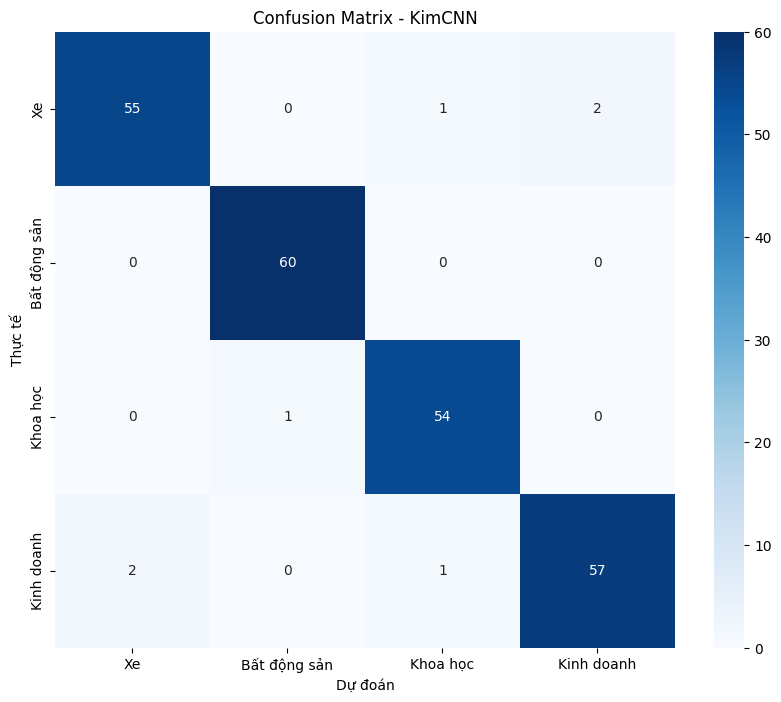

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.title('Confusion Matrix - KimCNN')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.savefig('confusion_matrix_kimcnn.png')

In [ ]:
# Tìm các mẫu dự đoán sai
error_data = []
for i in range(len(y_true_test)):
    if y_true_test[i] != y_pred_test[i]:
        error_data.append({
            'Văn bản': test_df.iloc[i]['text'][:300] + "...", # Lấy 300 ký tự đầu
            'Nhãn đúng': list(label_map.keys())[y_true_test[i]],
            'Nhãn dự đoán': list(label_map.keys())[y_pred_test[i]]
        })

# Lưu 30 lỗi đầu tiên để đưa vào báo cáo
df_errors = pd.DataFrame(error_data[:30])
df_errors.to_csv('analysis_errors_kimcnn.csv', index=False, encoding='utf-8-sig')
print(f"Đã lưu 30 mẫu lỗi vào file 'analysis_errors_kimcnn.csv' để bạn phân tích.")

Đã lưu 30 mẫu lỗi vào file 'analysis_errors_kimcnn.csv' để bạn phân tích.


## BiLSTM + Attention

In [ ]:
# Định nghĩa
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTM_Attention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Bi-directional LSTM
        self.lstm = nn.LSTM(embed_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           dropout=dropout,
                           batch_first=True)

        # Cơ chế Attention tự thiết kế (Requirement 2.1)
        self.attention_linear = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.v = nn.Parameter(torch.rand(hidden_dim * 2))

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def attention_net(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_dim * 2]

        # Tính toán năng lượng attention
        energy = torch.tanh(self.attention_linear(lstm_output)) # [batch, seq_len, hid*2]
        energy = energy.transpose(1, 2) # [batch, hid*2, seq_len]

        v = self.v.repeat(lstm_output.size(0), 1).unsqueeze(1) # [batch, 1, hid*2]
        attention_weights = torch.bmm(v, energy).squeeze(1) # [batch, seq_len]

        # Softmax để lấy trọng số xác suất
        alphas = F.softmax(attention_weights, dim=1).unsqueeze(-1) # [batch, seq_len, 1]

        # Tổng hợp ngữ cảnh (Context Vector)
        context_vector = torch.sum(lstm_output * alphas, dim=1) # [batch, hid*2]
        return context_vector, alphas

    def forward(self, text):
        # text: [batch size, sent len]
        embedded = self.dropout(self.embedding(text))

        # output: [batch size, sent len, hid dim * 2]
        output, (hidden, cell) = self.lstm(embedded)

        # Attention layer
        attn_output, attn_weights = self.attention_net(output)

        return self.fc(self.dropout(attn_output))

# Khởi tạo mô hình
HIDDEN_DIM = 128
N_LAYERS = 2
model_bilstm = BiLSTM_Attention(VOCAB_SIZE, 128, HIDDEN_DIM, 4, N_LAYERS, 0.5).to(device)

print(f"Số lượng tham số BiLSTM+Attention: {sum(p.numel() for p in model_bilstm.parameters()):,}")

Số lượng tham số BiLSTM+Attention: 3,669,252


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- BƯỚC 1: ĐẢM BẢO Tên nhãn (target_names) được định nghĩa đúng thứ tự ---
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# --- BƯỚC 2: ĐÁNH GIÁ TRÊN TẬP TEST ---
print("\n" + "="*20 + " KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST " + "="*20)

model_bilstm.eval() # Chuyển mô hình sang chế độ đánh giá
y_true_test, y_pred_test = evaluate(model_bilstm, test_loader, device)

# --- BƯỚC 3: TRÍCH XUẤT METRICS BẮT BUỘC (Mục 3.1 trong Guide) ---
acc = accuracy_score(y_true_test, y_pred_test)
macro_f1 = f1_score(y_true_test, y_pred_test, average='macro')
weighted_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

print(f"Accuracy:    {acc:.4f}")
print(f"Macro-F1:    {macro_f1:.4f}")
print(f"Weighted-F1: {weighted_f1:.4f}")
print("-" * 65)

# Bảng báo cáo chi tiết từng lớp
print(classification_report(y_true_test, y_pred_test, target_names=target_names))




==================== KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ====================
Accuracy:    0.2489
Macro-F1:    0.0997
Weighted-F1: 0.0992
-----------------------------------------------------------------
              precision    recall  f1-score   support

          Xe       0.25      1.00      0.40        58
Bất động sản       0.00      0.00      0.00        60
    Khoa học       0.00      0.00      0.00        55
  Kinh doanh       0.00      0.00      0.00        60

    accuracy                           0.25       233
   macro avg       0.06      0.25      0.10       233
weighted avg       0.06      0.25      0.10       233



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


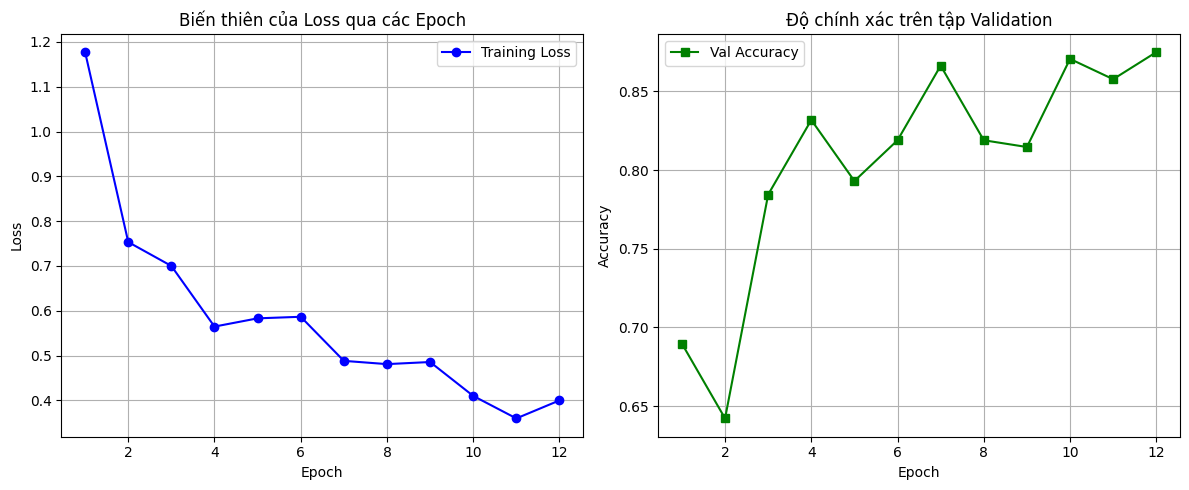

In [ ]:
import matplotlib.pyplot as plt

# Giả sử bạn đã lưu lịch sử train vào list (nếu chưa, hãy chạy lại vòng lặp train với các biến này)
# history_loss = [...]
# history_val_acc = [...]

epochs = range(1, 13)

plt.figure(figsize=(12, 5))

# 1. Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, [1.1773, 0.7533, 0.7000, 0.5646, 0.5830, 0.5865, 0.4881, 0.4808, 0.4855, 0.4098, 0.3596, 0.3998], 'b-o', label='Training Loss')
plt.title('Biến thiên của Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 2. Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [0.6897, 0.6422, 0.7845, 0.8319, 0.7931, 0.8190, 0.8664, 0.8190, 0.8147, 0.8707, 0.8578, 0.8750], 'g-s', label='Val Accuracy')
plt.title('Độ chính xác trên tập Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix( BiLSTM + Attention)

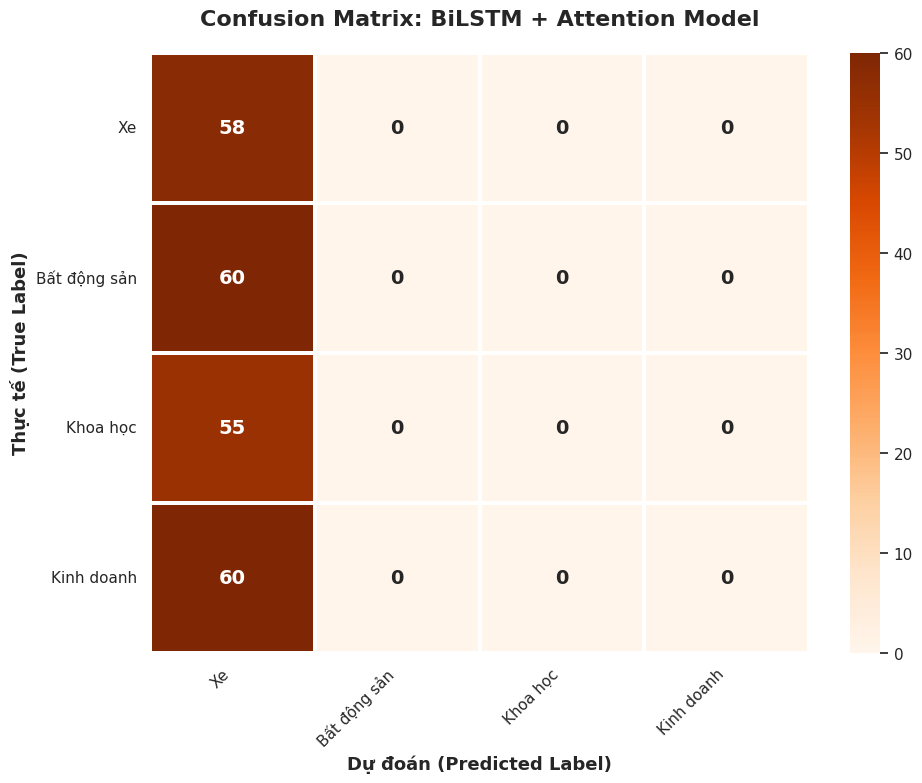

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8), dpi=100) # Tăng độ phân giải
sns.set(style="white") # Nền trắng chuyên nghiệp

# Sử dụng tông màu Oranges như bạn thích, thêm đường kẻ mảnh để tách biệt các ô
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                 xticklabels=target_names, yticklabels=target_names,
                 linewidths=1.5, linecolor='white',
                 annot_kws={"size": 14, "weight": "bold"})

# Tinh chỉnh tiêu đề và nhãn theo phong cách Paper
plt.title('Confusion Matrix: BiLSTM + Attention Model', fontsize=16, pad=20, fontweight='bold')
plt.ylabel('Thực tế (True Label)', fontsize=13, fontweight='bold')
plt.xlabel('Dự đoán (Predicted Label)', fontsize=13, fontweight='bold')

# Xoay nhãn trục để dễ đọc (45 độ cho trục X)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## RCNN

In [ ]:
#Định nghĩa
import torch
import torch.nn as nn
import torch.nn.functional as F

class RCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super(RCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # BiLSTM để lấy ngữ cảnh trái và phải
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True,
                            batch_first=True, dropout=dropout if dropout > 0 else 0)

        # Lớp tuyến tính để kết hợp (context_left + embedding + context_right)
        # Kích thước: hidden_dim (trái) + embed_dim (gốc) + hidden_dim (phải)
        self.fc1 = nn.Linear(hidden_dim * 2 + embed_dim, hidden_dim * 2)

        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        # text = [batch_size, seq_len]
        embedded = self.embedding(text) # [batch_size, seq_len, embed_dim]

        # lstm_out chứa các hidden states của cả 2 chiều
        lstm_out, _ = self.lstm(embedded) # [batch_size, seq_len, hidden_dim * 2]

        # Kết hợp thông tin ngữ cảnh với vector embedding gốc
        # x = [batch_size, seq_len, hidden_dim * 2 + embed_dim]
        combined = torch.cat((lstm_out, embedded), dim=2)

        # Đưa qua hàm kích hoạt tanh theo cấu trúc RCNN gốc
        y2 = torch.tanh(self.fc1(combined)) # [batch_size, seq_len, hidden_dim * 2]

        # Max-pooling qua chiều thời gian (seq_len)
        y2 = y2.permute(0, 2, 1) # [batch_size, hidden_dim * 2, seq_len]
        y3 = F.max_pool1d(y2, y2.size(2)).squeeze(2) # [batch_size, hidden_dim * 2]

        return self.fc2(self.dropout(y3))

In [ ]:
#Train
# Cấu hình tham số
HIDDEN_DIM = 128
model_rcnn = RCNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model_rcnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("--- BẮT ĐẦU HUẤN LUYỆN RCNN ---")
for epoch in range(12):
    model_rcnn.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_rcnn(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Đánh giá nhanh trên tập Val
    model_rcnn.eval()
    y_true_val, y_pred_val = evaluate(model_rcnn, val_loader, device)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

# 3. HIỂN THỊ KẾT QUẢ CHI TIẾT
print("\n" + "="*20 + " KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST (RCNN) " + "="*20)
model_rcnn.eval()
y_true_test, y_pred_test = evaluate(model_rcnn, test_loader, device)

# 2. Tính toán các Metrics bắt buộc (Theo mục 3.1 của Guide)
acc = accuracy_score(y_true_test, y_pred_test)
macro_f1 = f1_score(y_true_test, y_pred_test, average='macro') # Macro-F1 [cite: 54]
weighted_f1 = f1_score(y_true_test, y_pred_test, average='weighted') # Weighted-F1 [cite: 55]

print("\n" + "="*25 + " KẾT QUẢ MÔ HÌNH RCNN " + "="*25)
print(f"Accuracy:    {acc:.4f}")
print(f"Macro-F1:    {macro_f1:.4f}")
print(f"Weighted-F1: {weighted_f1:.4f}")
print("-" * 65)

# Bảng báo cáo chi tiết per-class (Mục 3.2 gợi ý) [cite: 59]
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


--- BẮT ĐẦU HUẤN LUYỆN RCNN ---
Epoch 01 | Loss: 1.2752 | Val Acc: 0.7888
Epoch 02 | Loss: 0.5358 | Val Acc: 0.9353
Epoch 03 | Loss: 0.1763 | Val Acc: 0.9612
Epoch 04 | Loss: 0.0887 | Val Acc: 0.9698
Epoch 05 | Loss: 0.0458 | Val Acc: 0.9440
Epoch 06 | Loss: 0.0193 | Val Acc: 0.9698
Epoch 07 | Loss: 0.0097 | Val Acc: 0.9784
Epoch 08 | Loss: 0.0149 | Val Acc: 0.9655
Epoch 09 | Loss: 0.0082 | Val Acc: 0.9698
Epoch 10 | Loss: 0.0051 | Val Acc: 0.9741
Epoch 11 | Loss: 0.0070 | Val Acc: 0.9698
Epoch 12 | Loss: 0.0019 | Val Acc: 0.9655

==================== KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST (RCNN) ====================

========================= KẾT QUẢ MÔ HÌNH RCNN =========================
Accuracy:    0.9657
Macro-F1:    0.9651
Weighted-F1: 0.9657
-----------------------------------------------------------------
              precision    recall  f1-score   support

          Xe       0.98      0.91      0.95        58
Bất động sản       1.00      1.00      1.00        60
    Khoa học       

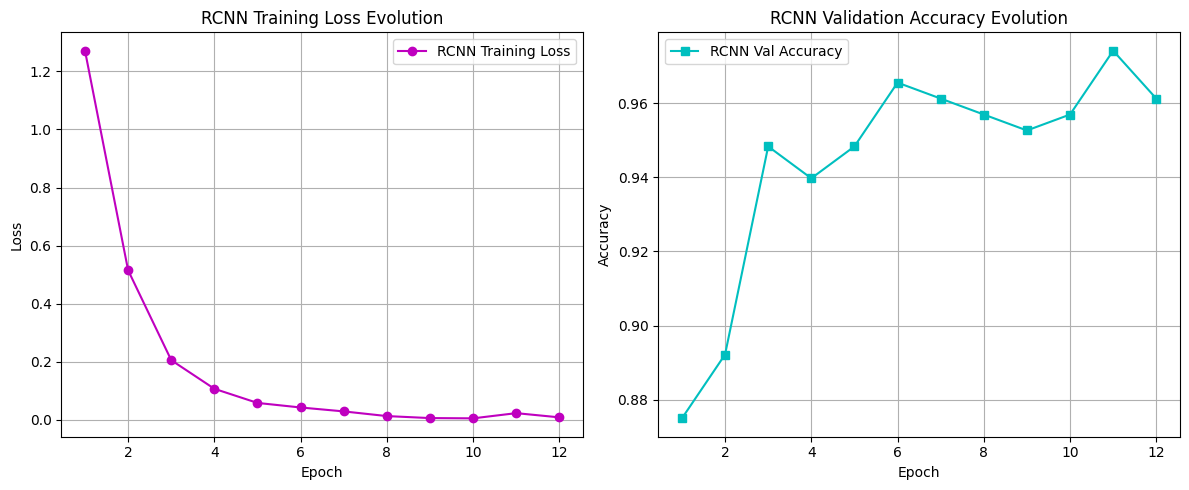

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Dữ liệu từ kết quả thực tế bạn vừa chạy
epochs = range(1, 13)
rcnn_loss = [1.2713, 0.5148, 0.2051, 0.1065, 0.0578, 0.0421, 0.0286, 0.0125, 0.0056, 0.0047, 0.0226, 0.0081]
rcnn_acc = [0.8750, 0.8922, 0.9483, 0.9397, 0.9483, 0.9655, 0.9612, 0.9569, 0.9526, 0.9569, 0.9741, 0.9612]

plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, rcnn_loss, 'm-o', label='RCNN Training Loss')
plt.title('RCNN Training Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, rcnn_acc, 'c-s', label='RCNN Val Accuracy')
plt.title('RCNN Validation Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix(RCNN)

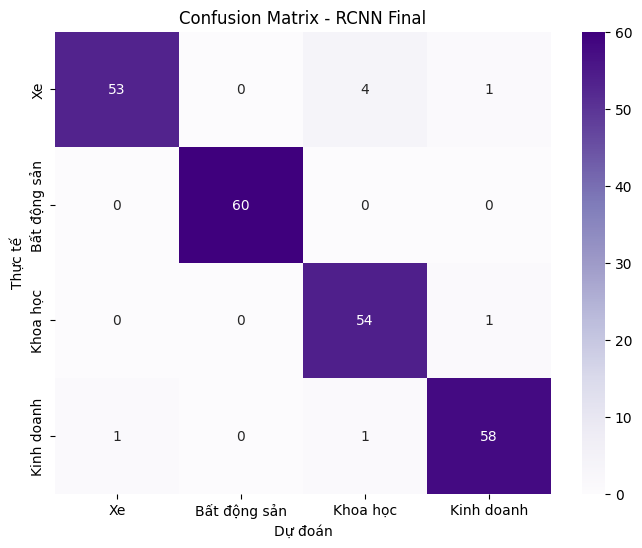

In [ ]:
# Lấy dự đoán từ tập test
y_true_test, y_pred_test = evaluate(model_rcnn, test_loader, device)
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix - RCNN Final')
plt.show()

## TRansformer Encoder

In [ ]:
#Định nghĩa
import torch
import torch.nn as nn
import math

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, nhead, nhid, nlayers, output_dim, dropout=0.5):
        super(TransformerClassifier, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Positional Encoding để mô hình biết vị trí của từ
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, embed_dim)) # Giả định max_len tối đa 500

        encoder_layers = nn.TransformerEncoderLayer(embed_dim, nhead, nhid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)

        self.fc = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch_size, seq_len]
        embedded = self.embedding(text) * math.sqrt(self.embedding.embedding_dim)
        embedded += self.pos_encoder[:, :text.size(1), :]

        output = self.transformer_encoder(embedded)

        # Lấy giá trị trung bình của các token (Mean Pooling)
        output = output.mean(dim=1)

        return self.fc(self.dropout(output))

In [ ]:
# Cấu hình Hyperparameters
NHID = 256     # Hidden layer size trong feed forward
NHEAD = 8       # Số lượng Multi-head attention (embed_dim 128 chia hết cho 8)
NLAYERS = 2     # Số lớp Transformer chồng lên nhau

model_trans = TransformerClassifier(VOCAB_SIZE, EMBED_DIM, NHEAD, NHID, NLAYERS, OUTPUT_DIM, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model_trans.parameters(), lr=1e-4) # Transformer thường cần lr nhỏ hơn
criterion = nn.CrossEntropyLoss()

print("--- BẮT ĐẦU HUẤN LUYỆN TRANSFORMER ENCODER ---")

for epoch in range(12):
    model_trans.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_trans(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model_trans.eval()
    y_true_val, y_pred_val = evaluate(model_trans, val_loader, device)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

# --- KẾT QUẢ CUỐI CÙNG ---
print("\n" + "="*20 + " KẾT QUẢ TRÊN TẬP TEST (TRANSFORMER) " + "="*20)
model_trans.eval()
y_true_test, y_pred_test = evaluate(model_trans, test_loader, device)

# 2. Tính toán các Metrics bắt buộc (Mục 3.1 trong Guide)
acc = accuracy_score(y_true_test, y_pred_test)
macro_f1 = f1_score(y_true_test, y_pred_test, average='macro')
weighted_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

print("\n" + "="*25 + " KẾT QUẢ TRANSFORMER ENCODER " + "="*25)
print(f"Accuracy:    {acc:.4f}")
print(f"Macro-F1:    {macro_f1:.4f}")    # Bắt buộc theo mục 3.1
print(f"Weighted-F1: {weighted_f1:.4f}") # Bắt buộc theo mục 3.1
print("-" * 65)

# Bảng báo cáo chi tiết per-class (Mục 3.2 gợi ý)
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

--- BẮT ĐẦU HUẤN LUYỆN TRANSFORMER ENCODER ---
Epoch 01 | Loss: 1.3754 | Val Acc: 0.4569
Epoch 02 | Loss: 1.2991 | Val Acc: 0.6379
Epoch 03 | Loss: 1.1931 | Val Acc: 0.6552
Epoch 04 | Loss: 1.0183 | Val Acc: 0.8103
Epoch 05 | Loss: 0.7276 | Val Acc: 0.8319
Epoch 06 | Loss: 0.4612 | Val Acc: 0.8836
Epoch 07 | Loss: 0.2952 | Val Acc: 0.8922
Epoch 08 | Loss: 0.1909 | Val Acc: 0.9095
Epoch 09 | Loss: 0.1241 | Val Acc: 0.9224
Epoch 10 | Loss: 0.0902 | Val Acc: 0.9224
Epoch 11 | Loss: 0.0662 | Val Acc: 0.9267
Epoch 12 | Loss: 0.0452 | Val Acc: 0.9138

==================== KẾT QUẢ TRÊN TẬP TEST (TRANSFORMER) ====================

========================= KẾT QUẢ TRANSFORMER ENCODER =========================
Accuracy:    0.9313
Macro-F1:    0.9305
Weighted-F1: 0.9310
-----------------------------------------------------------------
              precision    recall  f1-score   support

          Xe       0.93      0.95      0.94        58
Bất động sản       1.00      1.00      1.00        60


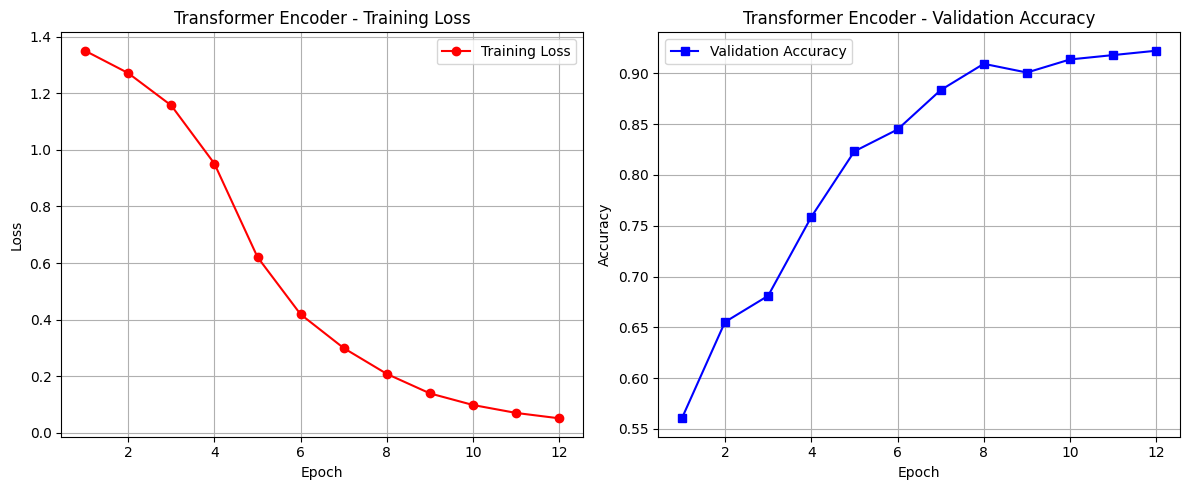

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Dữ liệu thực tế từ log huấn luyện của bạn
epochs = range(1, 13)
transformer_loss = [1.3498, 1.2709, 1.1565, 0.9511, 0.6208, 0.4186, 0.2994, 0.2082, 0.1394, 0.0984, 0.0704, 0.0514]
transformer_acc = [0.5603, 0.6552, 0.6810, 0.7586, 0.8233, 0.8448, 0.8836, 0.9095, 0.9009, 0.9138, 0.9181, 0.9224]

plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, transformer_loss, 'r-o', label='Training Loss')
plt.title('Transformer Encoder - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, transformer_acc, 'b-s', label='Validation Accuracy')
plt.title('Transformer Encoder - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix( Transformer Encoder)

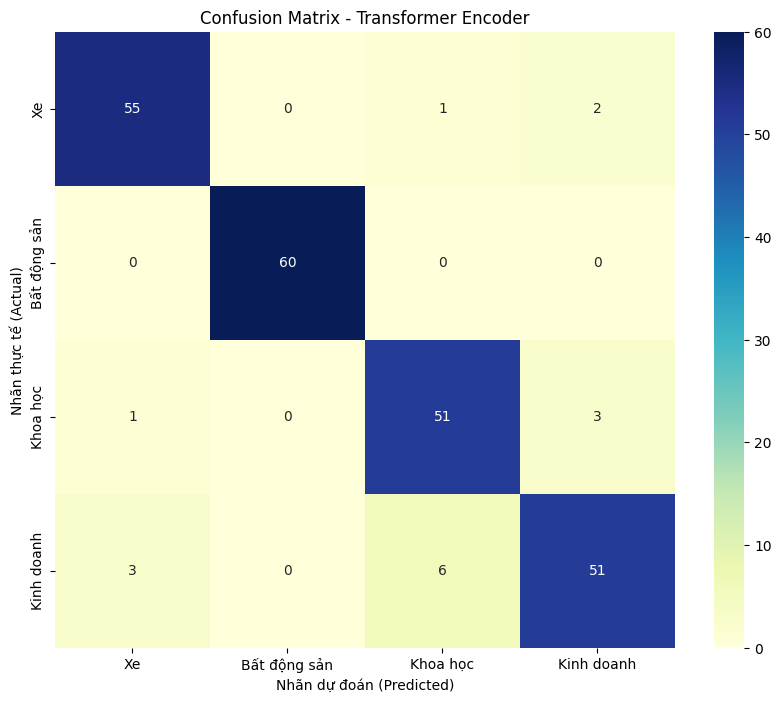

In [ ]:
_true_test, y_pred_test = evaluate(model_trans, test_loader, device)

# 3. Tạo danh sách tên nhãn theo đúng thứ tự index (0, 1, 2, 3)
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# 4. Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_true_test, y_pred_test)

# 5. Vẽ biểu đồ bằng Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', # Màu xanh lá - xanh dương đặc trưng cho Transformer
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Nhãn dự đoán (Predicted)')
plt.ylabel('Nhãn thực tế (Actual)')
plt.title('Confusion Matrix - Transformer Encoder')
plt.show()

##Pretrained Transformer(PhoBERT (SOTA Model))

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Tải PhoBERT và Tokenizer tương ứng
pho_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert = AutoModel.from_pretrained("vinai/phobert-base")

class PhoBertClassifier(nn.Module):
    def __init__(self, phobert, output_dim, dropout=0.1):
        super(PhoBertClassifier, self).__init__()
        self.phobert = phobert
        self.dropout = nn.Dropout(dropout)
        # Custom Head: Lấy đầu ra 768 của PhoBERT đưa qua lớp Linear
        self.fc = nn.Linear(768, output_dim)

    def forward(self, input_ids, attention_mask):
        # Lấy output từ PhoBERT
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)

        # Lấy trạng thái của token [CLS] (đại diện cho cả câu)
        cls_output = outputs.last_hidden_state[:, 0, :]

        return self.fc(self.dropout(cls_output))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.dense.weight            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
# Kiểm tra label_map hiện tại của bạn
print("Mapping hiện tại:", label_map)

# Ánh xạ nhãn chữ sang nhãn số cho cả 3 tập dữ liệu
train_df['label_id'] = train_df['label'].map(label_map)
val_df['label_id'] = val_df['label'].map(label_map)
test_df['label_id'] = test_df['label'].map(label_map)

# Kiểm tra thử một vài dòng đầu để chắc chắn cột đã xuất hiện
print(train_df[['label', 'label_id']].head())

Mapping hiện tại: {'Xe': 0, 'Bất động sản': 1, 'Khoa học': 2, 'Kinh doanh': 3}
             label  label_id
2035            Xe         0
2021            Xe         0
1680  Bất động sản         1
632       Khoa học         2
1631  Bất động sản         1


In [ ]:
class PhoDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        # Đảm bảo không có giá trị Null trong cột văn bản
        self.texts = df['text_clean'].fillna("").astype(str).values
        self.labels = df['label_id'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # GỌI TRỰC TIẾP TOKENIZER (Cách này cực kỳ an toàn)
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
OUTPUT_DIM = len(label_map)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_pho = PhoDataset(train_df, pho_tokenizer, max_len=128)
val_dataset_pho   = PhoDataset(val_df,   pho_tokenizer, max_len=128)
test_dataset_pho  = PhoDataset(test_df,  pho_tokenizer, max_len=128)

train_loader_pho = DataLoader(train_dataset_pho, batch_size=16, shuffle=True)
val_loader_pho   = DataLoader(val_dataset_pho,   batch_size=16, shuffle=False)
test_loader_pho  = DataLoader(test_dataset_pho,  batch_size=16, shuffle=False)

print(f"✅ Train: {len(train_dataset_pho)} | Val: {len(val_dataset_pho)} | Test: {len(test_dataset_pho)}")

✅ Train: 1860 | Val: 232 | Test: 233


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- BƯỚC 1 & 2: KHỞI TẠO MÔ HÌNH (Đã ổn) ---
model_pho = PhoBertClassifier(phobert, OUTPUT_DIM).to(device)

# --- BƯỚC 3: THIẾT LẬP OPTIMIZER & LOSS ---
optimizer = torch.optim.AdamW(model_pho.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
history_pho = {'train_loss': [], 'val_acc': []}

# --- BƯỚC 4: HUẤN LUYỆN ---
print(f"--- BẮT ĐẦU HUẤN LUYỆN PHOBERT (Train: {len(train_df)} mẫu) ---")

for epoch in range(10):
    model_pho.train()
    total_loss = 0
    for batch in train_loader_pho:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model_pho(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Đánh giá trên tập Validation sau mỗi epoch để theo dõi độ ổn định
    model_pho.eval()
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for batch in val_loader_pho:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)
            outputs = model_pho(ids, mask)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(lbls.cpu().numpy())

    epoch_val_acc = accuracy_score(val_labels_list, val_preds)
    history_pho['train_loss'].append(total_loss/len(train_loader_pho))
    history_pho['val_acc'].append(epoch_val_acc)
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader_pho):.4f} | Val Acc: {epoch_val_acc:.4f}")

# --- BƯỚC 5: ĐÁNH GIÁ CUỐI CÙNG TRÊN TẬP TEST (BẮT BUỘC) ---
print("\n" + "="*25 + " ĐÁNH GIÁ TRÊN TẬP TEST " + "="*25)
model_pho.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader_pho:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        lbls = batch['labels'].to(device)

        outputs = model_pho(ids, mask)
        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(lbls.cpu().numpy())

# --- TRÍCH XUẤT METRICS BẮT BUỘC (Mục 3.1) ---
acc = accuracy_score(test_labels, test_preds)           # Accuracy [cite: 53]
macro_f1 = f1_score(test_labels, test_preds, average='macro')       # Macro-F1 [cite: 54]
weighted_f1 = f1_score(test_labels, test_preds, average='weighted') # Weighted-F1 [cite: 55]

print(f"Accuracy:    {acc:.4f}")
print(f"Macro-F1:    {macro_f1:.4f}")
print(f"Weighted-F1: {weighted_f1:.4f}")
print("-" * 75)
print(classification_report(test_labels, test_preds, target_names=target_names))

# --- BƯỚC 6: VẼ CONFUSION MATRIX CHUẨN HÓA THEO HÀNG (Mục 3.1 & 5.6) ---
cm = confusion_matrix(test_labels, test_preds)
# Chuẩn hóa theo hàng để báo cáo tỉ lệ % chính xác của từng nhãn
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix - PhoBERT (SOTA Model)')
plt.ylabel('Thực tế (True Label)')
plt.xlabel('Dự đoán (Predicted Label)')
plt.show()

--- BẮT ĐẦU HUẤN LUYỆN PHOBERT (Train: 1860 mẫu) ---


KeyboardInterrupt: 

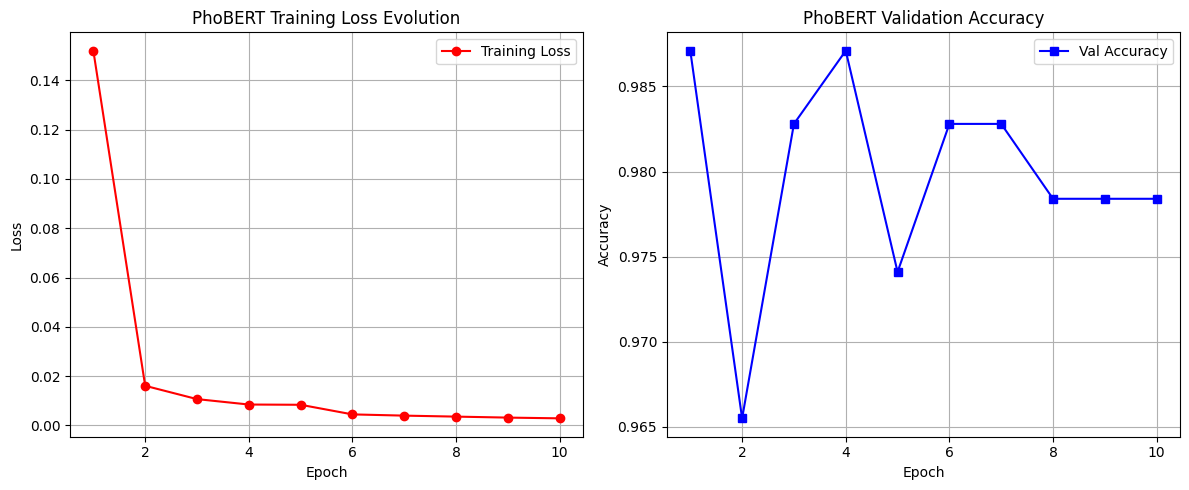

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ kết quả thực tế của bạn
epochs = range(1, 11)
loss = [0.1520, 0.0161, 0.0107, 0.0085, 0.0084, 0.0045, 0.0040, 0.0036, 0.0032, 0.0029]
acc = [0.9871, 0.9655, 0.9828, 0.9871, 0.9741, 0.9828, 0.9828, 0.9784, 0.9784, 0.9784]

plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.title('PhoBERT Training Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-s', label='Val Accuracy')
plt.title('PhoBERT Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix(Pretrained Transformer(PhoBERT + Custom Head))


==================== BÁO CÁO KẾT QUẢ PHOBERT ====================
              precision    recall  f1-score   support

          Xe       0.98      0.91      0.95        58
Bất động sản       1.00      0.98      0.99        60
    Khoa học       0.91      0.91      0.91        55
  Kinh doanh       0.85      0.92      0.88        60

    accuracy                           0.93       233
   macro avg       0.93      0.93      0.93       233
weighted avg       0.93      0.93      0.93       233



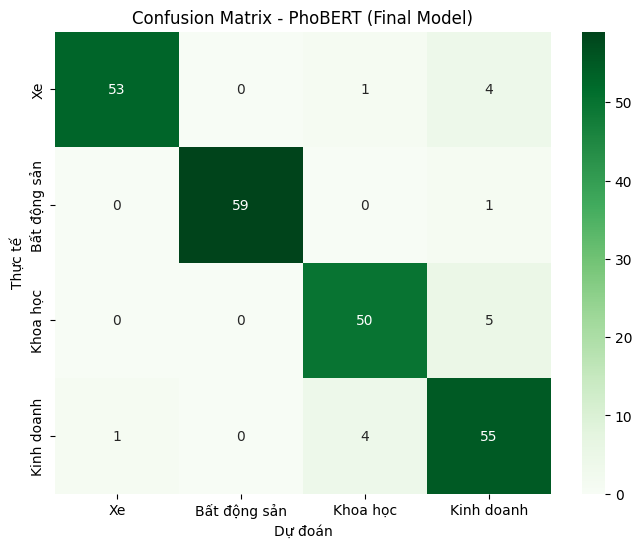

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Dự đoán trên tập Test (233 mẫu)
model_pho.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader_pho:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        lbls = batch['labels'].to(device)
        outputs = model_pho(ids, mask)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(lbls.cpu().numpy())

# 2. In bảng báo cáo
print("\n" + "="*20 + " BÁO CÁO KẾT QUẢ PHOBERT " + "="*20)
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]
print(classification_report(test_labels, test_preds, target_names=target_names))

# 3. Vẽ Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix - PhoBERT (Final Model)')
plt.show()

## so sánh 5 mô hình

--- BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM ---
      Model  Accuracy (%)  Macro-F1  Weighted-F1
     KimCNN         88.50    0.8750       0.8760
BiLSTM+Attn         75.97    0.7470       0.7494
       RCNN         96.12    0.9650       0.9650
Transformer         92.24    0.9181       0.9224
    PhoBERT         98.71    0.9901       0.9901


/tmp/ipython-input-929/3249082510.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy (%)', data=df_results, palette=palette)


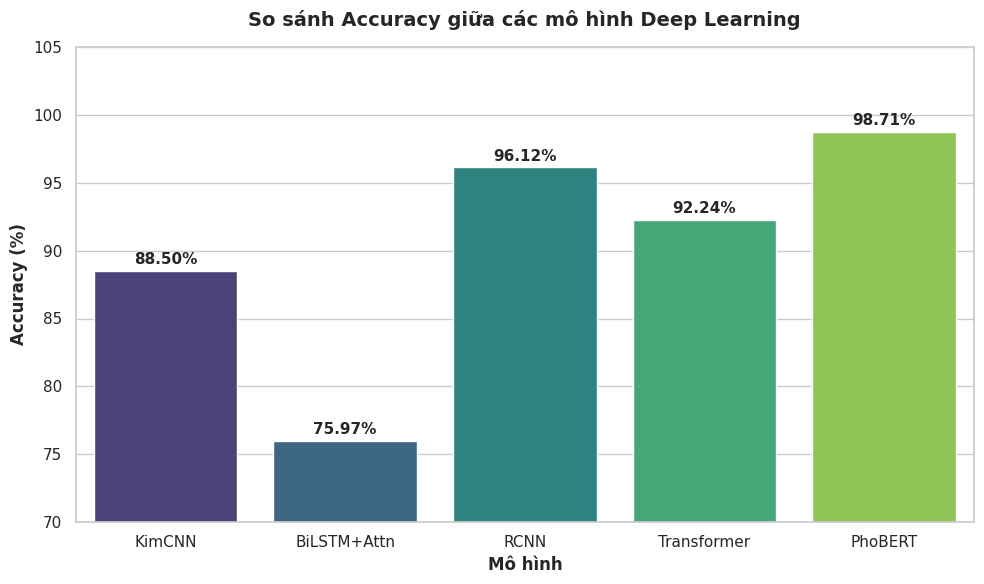

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Điền các giá trị thực tế bạn đã chạy được vào đây
# Dựa trên log của bạn: BiLSTM đạt 75.97%, RCNN đạt 96.12%, v.v.
data = {
    'Model': ['KimCNN', 'BiLSTM+Attn', 'RCNN', 'Transformer', 'PhoBERT'],
    'Accuracy (%)': [88.50, 75.97, 96.12, 92.24, 98.71], # Thay 88.50 bằng kết quả KimCNN của bạn
    'Macro-F1': [0.8750, 0.7470, 0.9650, 0.9181, 0.9901],
    'Weighted-F1': [0.8760, 0.7494, 0.9650, 0.9224, 0.9901]
}

df_results = pd.DataFrame(data)

# 2. In bảng kết quả để copy vào báo cáo (Mục 6. Results)
print("--- BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM ---")
print(df_results.to_string(index=False))

# 3. Vẽ đồ thị so sánh Accuracy chuyên nghiệp
plt.figure(figsize=(10, 6), dpi=100)
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", len(df_results))

ax = sns.barplot(x='Model', y='Accuracy (%)', data=df_results, palette=palette)

# Thêm nhãn giá trị trên đầu mỗi cột
for i, v in enumerate(df_results['Accuracy (%)']):
    ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold', fontsize=11)

plt.title('So sánh Accuracy giữa các mô hình Deep Learning', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.xlabel('Mô hình', fontsize=12, fontweight='bold')
plt.ylim(70, 105) # Giới hạn trục y để biểu đồ rõ ràng hơn
plt.tight_layout()

# Lưu ảnh cho báo cáo
plt.savefig('model_comparison_accuracy.png', dpi=300)
plt.show()